# Proyecto mineria de datos

libraries

In [1]:
import codecs
import glob
import json
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import string
import time

from ggplot import *
from math import log
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from nltk import sent_tokenize, word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint
from scipy import stats, integrate, ndimage
from scipy.misc import imread
from sklearn import manifold, datasets, metrics
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#nltk.download()
%matplotlib inline
mpl.style.use('ggplot')

## Load

In [2]:
with open('test2.json') as data_file:    
    data = json.load(data_file)

### Data structure

In [3]:
print "páginas de registros:", len(data)
print "claves por página:", data[0].keys()
print "claves de \"photos\":" ,data[0]["photos"].keys()
print "fotos por página", len(data[0]["photos"]["photo"])
print "claves por \"photo\"",pd.DataFrame( data[0]["photos"]["photo"][0].keys() )

páginas de registros: 500
claves por página: [u'photos', u'stat']
claves de "photos": [u'photo', u'total', u'pages', u'page', u'perpage']
fotos por página 250
claves por "photo"                        0
0              pathalias
1          geo_is_public
2               place_id
3           media_status
4                  owner
5                     id
6   datetakengranularity
7                  woeid
8          geo_is_friend
9         geo_is_contact
10             datetaken
11              isfriend
12                secret
13             ownername
14              latitude
15              accuracy
16              isfamily
17                 media
18           description
19                  tags
20                  farm
21         geo_is_family
22      datetakenunknown
23              ispublic
24                 url_s
25             longitude
26                server
27               context
28              height_s
29                 title
30               width_s


## Preprocessing

### Load and cleaning data

In [4]:
Lat_l=[]
Long_l=[]
Tags_l=[]
Ids_l=[]
Urls_l=[]
Datetaken_l=[]
Ownername_l=[]
Description_l=[]
Title_l=[]

for datas in data:
    Lat_datas=[float(pic["latitude"]) for pic in datas["photos"]["photo"]]
    Long_datas=[float(pic["longitude"]) for pic in datas["photos"]["photo"]]
    Tags_datas=[pic["tags"] for pic in datas["photos"]["photo"]]
    Ids_datas=[pic["id"] for pic in datas["photos"]["photo"]]
    Urls_datas=[pic["url_s"] for pic in datas["photos"]["photo"]]
    Datetaken_datas=[pic["datetaken"] for pic in datas["photos"]["photo"]]
    Ownername_datas=[pic["ownername"] for pic in datas["photos"]["photo"]]
    Description_datas=[pic["description"]["_content"] for pic in datas["photos"]["photo"]]
    Title_datas=[pic["title"] for pic in datas["photos"]["photo"]]
    
    Lat_l.extend(Lat_datas)
    Long_l.extend(Long_datas)
    Tags_l.extend(Tags_datas)
    Ids_l.extend(Ids_datas)
    Urls_l.extend(Urls_datas)
    Datetaken_l.extend(Datetaken_datas)
    Ownername_l.extend(Ownername_datas)
    Description_l.extend(Description_datas)
    Title_l.extend(Title_datas)



### Removing repeated data

In [5]:
Ids=list(set(Ids_l))
Lat=[Lat_l[Ids_l.index(pict)]for pict in Ids]
Long=[Long_l[Ids_l.index(pict)]for pict in Ids]
Tags=[Tags_l[Ids_l.index(pict)]for pict in Ids]

Datetaken=[Datetaken_l[Ids_l.index(pict)]for pict in Ids]
Ownername=[Ownername_l[Ids_l.index(pict)]for pict in Ids]
Description=[Description_l[Ids_l.index(pict)]for pict in Ids]
Title=[Title_l[Ids_l.index(pict)]for pict in Ids]

print "Latitudes",len(Lat),"Longitudes",len(Long),"Tags",len(Tags)
#print "Fechas", len(Datetaken), "Usuarios", len(Ownername), "Descripciones",len(Description), "Títulos",len(Title)#, "",len(),

Latitudes 4000 Longitudes 4000 Tags 4000


In [6]:
# Create a unique string of the texts found on tags, titles and descriptions:
Texts=[]
for i in range(len(Ids)):
    Texts.append(" ".join ([Title[i],Description[i],Tags[i]]))

print len (Texts)

4000


## Texts processing

### MATRIZ tf-idf sin stemming


In [7]:
tokens_list = []
counter = 0

regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

regex_rem = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
tokens_remove = re.compile(r'('+'|'.join(regex_rem)+')', re.VERBOSE | re.IGNORECASE)

punctuation = list(string.punctuation)
stopEn = stopwords.words('english') + punctuation + ['rt', 'via']
stopEs = stopwords.words('spanish') + punctuation + ['rt', 'via']

def tokenize(s):
    return tokens_re.findall(s)
          
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens

In [8]:
#with open(path+'iot_data_130516.txt', 'r') as f:
#for line in list(set(Tags)): #Unrepeated tags list (n:600)
#for line in Tags: #Total Tags List
for line in Texts: #Total Texts List
    #counter+=1
    #if counter == 500:
    #    break;
    tag = line
    tagString = ""
    for term in preprocess(tag):
        if not tokens_remove.search(term) and term not in stopEn and term not in stopEs:
            tagString = tagString + term + " "
    tokens_list.append(tagString)
    
#print counter

tfidf = TfidfVectorizer(max_df=0.5, min_df=2)
tfs = tfidf.fit_transform(tokens_list)

print "Dimensiones tf-idf",tfs.shape
#print tfidf
#print tfidf.idf_
#print tfs    


Dimensiones tf-idf (4000, 2410)


### Removing Stopwords

In [9]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
#tfidf = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='spanish')
tfs = tfidf.fit_transform(tokens_list)

print "Dimensiones tf-idf",tfs.shape
#print tfidf
#print tfidf.idf_
#print tfs  

#Tokens
#tokens_list#[0]

Dimensiones tf-idf (4000, 2358)


### Cosine similarity

In [10]:
similarity_matrix = cosine_similarity(tfs)
similarity_matrix.shape
#similarity_matrix[0,:]
#similarity_matrix[:,1]

(4000L, 4000L)

### Entropy

In [11]:
#Hamming distance
def hamming(x, y):
    sim = 0.0
    for i in range(len(x)):
        if x[i] == y[i] and x[i] != 0 and y[i] != 0:
            sim += 1
            
    sim = sim/len(x)
    return sim

#Entropy
def entropy(x):
    entropy = 0
    for i in range(0,len(x)-1):
        for j in range(i+1, len(x)):
            sim = hamming(x[i,:], x[j,:])
            if sim != 0:
                entropy += (sim*log(sim,2))+((1-sim)*log(sim,2))
    return -1*entropy


In [12]:
'''
#Entropy analisis
time_start=time.time()
entropyT = entropy(similarity_matrix)
dimensions = [] 
similarity_matrix = np.delete(similarity_matrix, (0), axis = 0)
for i in range(1,len(x)-1):
    entropyTemp = entropy(similarity_matrix)
    if(entropyT-entropyTemp < entropyT):
        similarity_matrix = np.delete(similarity_matrix, (i), axis = 0)
        dimensions.append(i)

time_end=time.time()

print "Tiempo de procesamiento:", time_end-time_start
print "Entropy"
print dimensions
print entropyT
#print entropy(similarity_matrix)'''


'\n#Entropy analisis\ntime_start=time.time()\nentropyT = entropy(similarity_matrix)\ndimensions = [] \nsimilarity_matrix = np.delete(similarity_matrix, (0), axis = 0)\nfor i in range(1,len(x)-1):\n    entropyTemp = entropy(similarity_matrix)\n    if(entropyT-entropyTemp < entropyT):\n        similarity_matrix = np.delete(similarity_matrix, (i), axis = 0)\n        dimensions.append(i)\n\ntime_end=time.time()\n\nprint "Tiempo de procesamiento:", time_end-time_start\nprint "Entropy"\nprint dimensions\nprint entropyT\n#print entropy(similarity_matrix)'

### Get terms in csv for association

In [13]:
#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")
#Tags[0]
counter = 0

Tags_good = []
Tags_csv = list(Tags)
headers = ""

for line in Tags:
    Tags_good.append(line.split(" "))
    
for line in Tags_good:
    if line[0] == '':
        Tags_good.remove(line)

for line in Tags_good:
    if counter < len(line):
        counter = len(line)

for i in range(0,counter):
    headers+=str(i)
    if i+1 != counter: 
        headers+=","
        
        
for line in Tags_csv:
    #line = line.replace(" ", ",")
    if(line == ""):
        Tags_csv.remove(line)

for i in range(0,len(Tags_csv)):
    #print len(Tags_csv[i]) 
    if len(Tags_good[i]) < counter:
           for j in range(len(Tags_good[i]),counter):
                   Tags_csv[i] += ' ?'

#print counter
#print headers
df = pd.DataFrame(Tags_csv)
df.to_excel("Tags.xls", header=headers, index=False)


## Plots

### Plot photos localization 

Bogotá coordinates

East long=-73.98

West long=-74.23

North lat=4.84

South lat=4.46

In [14]:
North=4.84
South=4.46
East=-73.98
West=-74.23

def map_dim(wide):
    high_m=abs(North-South)
    wide_m=abs(East-West)
    ratio=high_m/wide_m
    return([float(wide),float(wide)*ratio])

X, Y = np.mgrid[West:East:100j, South:North:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([Long, Lat])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

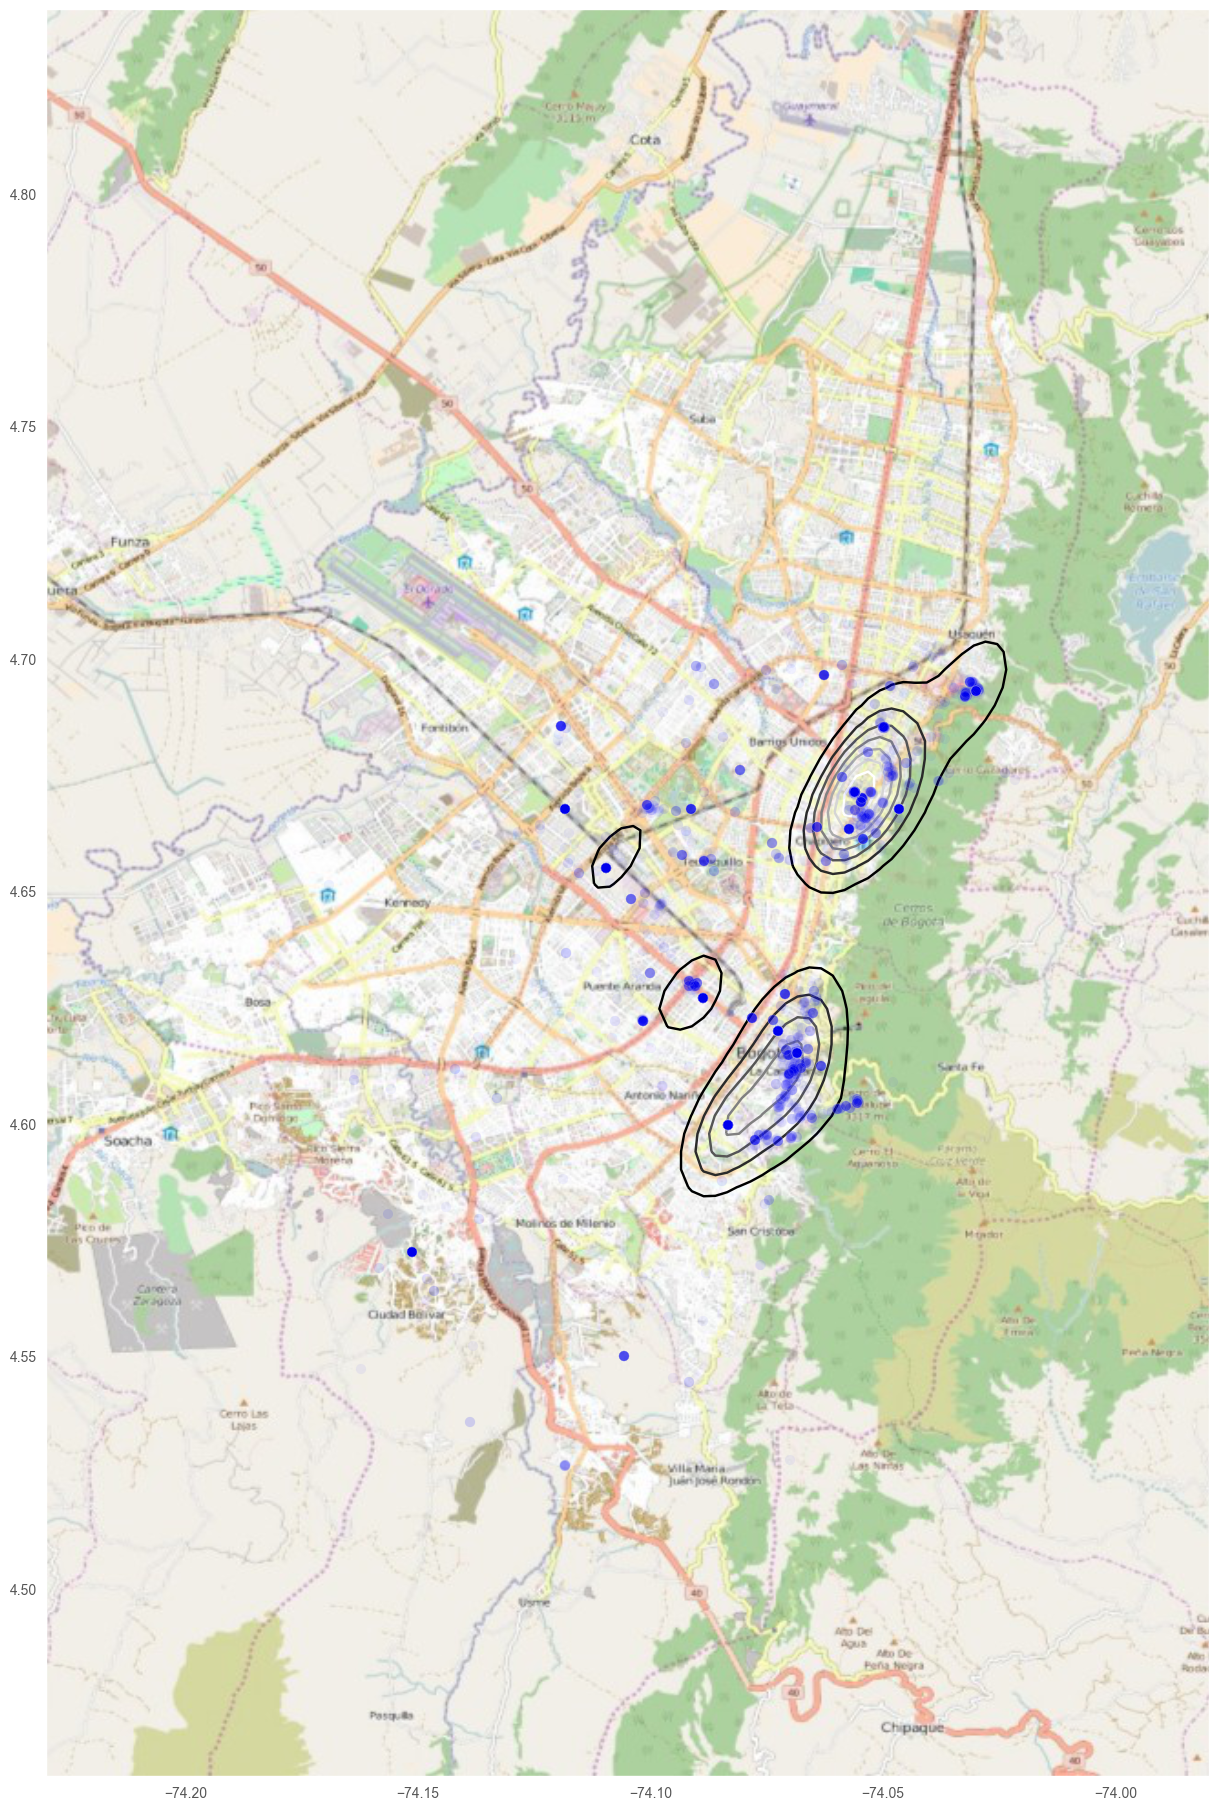

In [15]:
img = imread("map2.jpg")
plt.figure(figsize=(map_dim(15)[0],map_dim(15)[1]))
plt.imshow(img,zorder=1, extent=[-74.23, -73.98,4.46,  4.84])
plt.contour(X, Y, Z, cmap=cm.gray)
plt.scatter(Long, Lat, alpha=0.05,zorder=2, s=55)
plt.ylim(4.46,4.84)
plt.xlim(-74.23, -73.98)
plt.savefig('mapa_puntos.jpg')
plt.show()


### Plot Density by coordinates

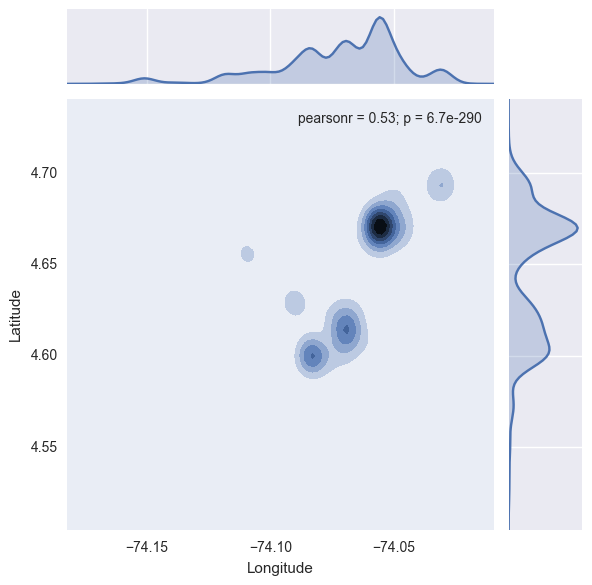

In [16]:
sns.set(color_codes=True)
arr_coordinates= np.column_stack((Long,Lat))
df_coordinates= pd.DataFrame(arr_coordinates, columns=["Longitude", "Latitude"])
sns.jointplot(x="Longitude", y="Latitude", data=df_coordinates, kind="kde");

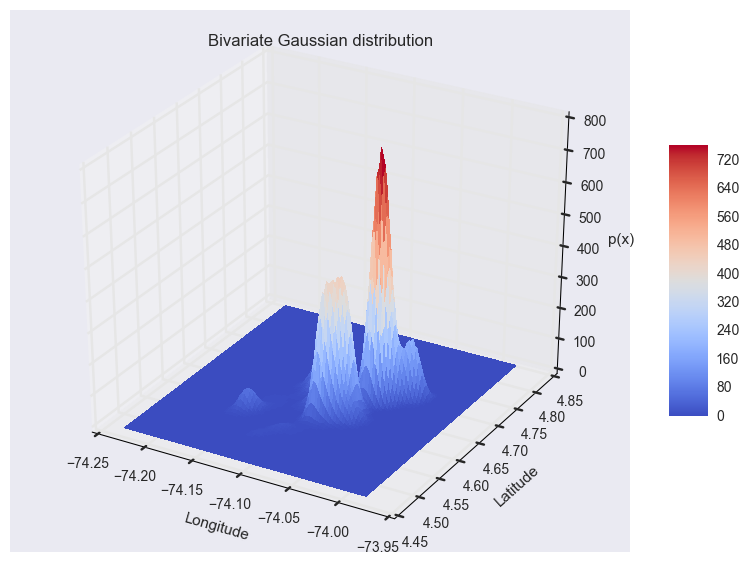

In [17]:
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1,
        cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False
    )

#ax.set_zlim(0, 0.2)
#ax.zaxis.set_major_locator(plt.LinearLocator(10))
#ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('p(x)')

plt.title('Bivariate Gaussian distribution')
fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

plt.show()

### Heatmap

Dimensiones tf-idf (499, 706)


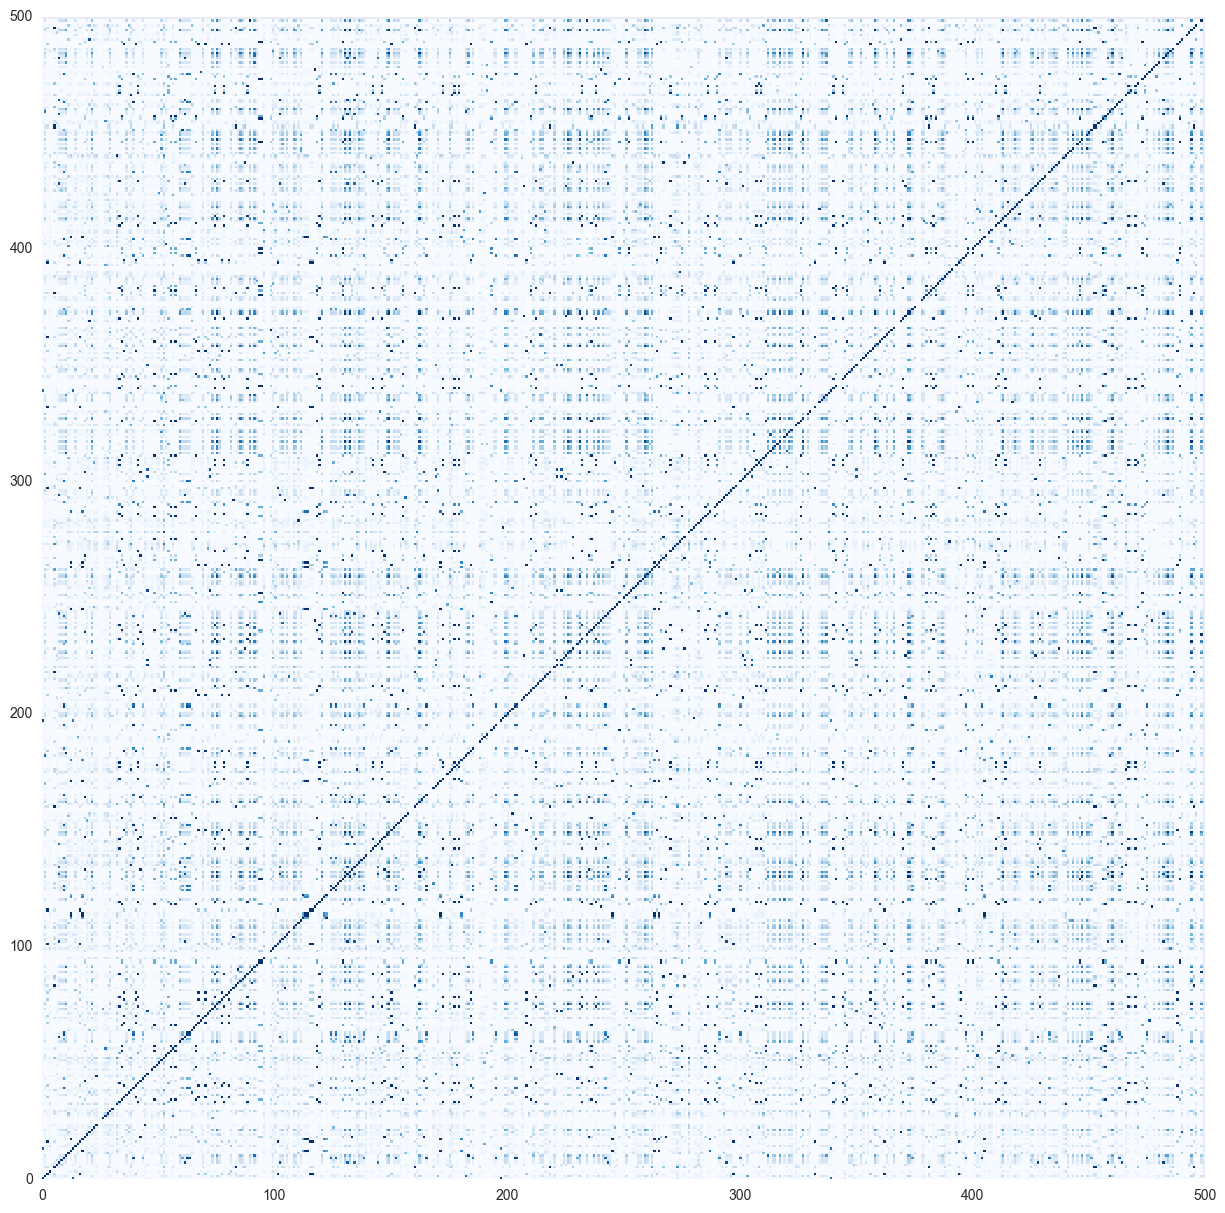

In [18]:
tokens_list_heat = []
counter=0
for line in list(set(Texts)): #Unrepeated Text List
#for line in Texts: #Total Texts List
    counter+=1
    if counter == 500:
        break;
    tag = line
    tagString = ""
    for term in preprocess(tag):
        if not tokens_remove.search(term) and term not in stopEn and term not in stopEs:
            tagString = tagString + term + " "
    tokens_list_heat.append(tagString)
    
#print counter

tfidf_heat = TfidfVectorizer(max_df=0.5, min_df=2)
tfs_s_heat = tfidf_heat.fit_transform(tokens_list_heat)

similarity_matrix_s_heat = cosine_similarity(tfs_s_heat)

print "Dimensiones tf-idf",tfs_s_heat.shape

plt.figure(figsize=(15,15))
heatmap = plt.pcolor(similarity_matrix_s_heat,cmap=mpl.cm.Blues )